# COVID-19 gene-environment interaction analysis

## Preliminaries and function definitions

The purpose of this notebook is to import, wrangle, post-process, and visualize the results of our COVID-19 risk factor genome-wide interaction study.

In [1]:
library(tidyverse)
if (!require(data.table)) install.packages("data.table")
if (!require(cowplot)) install.packages("cowplot")
if (!require(reticulate)) install.packages("reticulate")

fapi <- import("firecloud.api")

ws_namespace <- Sys.getenv('WORKSPACE_NAMESPACE')
ws_name <- Sys.getenv('WORKSPACE_NAME')
ws_bucket <- Sys.getenv('WORKSPACE_BUCKET')  # References workspace bucket ("gs://fc-secure-...")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: data.table


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


Loading required package: cowplot

Loading required package: reticulate



A set of base summary functions were retrieved from the summarize_GWIS.Rmd script (housed in our GitHub repository: https://github.com/large-scale-gxe-methods/gxe-utils).

In [2]:
make_manhattan <- function(data, pval_col, varID="RSID", chr_col="CHR", pos_col="POS", main="") {
  mh_data <- data %>%
    dplyr::rename(all_of(c(SNP=varID, CHR=chr_col, POS=pos_col, P=pval_col))) %>%
    filter(!is.na(P)) %>%
    mutate(P = ifelse(P == 0, min(1e-300, min(P[P != 0], na.rm=TRUE)), P),  # Remove P = 0
           nlp = -log10(P))
  # Trim points in crowded regions (credit to RaMWAS package for code snippet)
  yfac = as.integer(mh_data$nlp * 100) + 1L
  yorder = sort.list(yfac)
  yfac <- factor(yfac, levels=as.character(seq_len(max(yfac))))
  ygroup <- split(seq_along(yfac), yfac)
  for (i in seq_along(ygroup)) {
    if (length(ygroup[[i]]) > 300) {
      ygroup[[i]] <- sample(ygroup[[i]], size=300, replace=FALSE)
    }
  }
  keep <- unlist(ygroup, use.names=FALSE)
  mh_data <- mh_data %>%
    select(SNP, CHR, POS, nlp) %>%
    dplyr::slice(keep) %>%
    mutate(POS = as.numeric(as.character(POS)),
           CHR = factor(CHR, levels=1:22)) %>%
    arrange(CHR, POS) %>%
    mutate(pos_idx = seq(1, nrow(.)))
  chr_lengths <- sapply(1:22, function(chr) with(mh_data, max(POS[CHR == chr])))
  chr_lengths <- ifelse(is.infinite(chr_lengths), 0, chr_lengths)
  chr_start_pos <- cumsum(chr_lengths) - chr_lengths
  mh_data <- mh_data %>%
    mutate(x_coord = chr_start_pos[CHR] + POS,
           color = CHR,
    ) %>%
    arrange(as.integer(color), nlp) %>%
    distinct(SNP, .keep_all=TRUE)
  lims <- mh_data %>%
    group_by(CHR) %>%
    summarise(avg_coord = (min(x_coord) + max(x_coord)) / 2)
  newcols <- setNames(
    rep(x=c("#AAAAAA", "#8A8A8A"), length.out=22),  # Gray/dark gray for alternating chromosomes
    levels(factor(lims$CHR))
  )
  plt <- ggplot() +
    geom_point(data=mh_data, 
               aes(x=x_coord, y=nlp, color=factor(color)), 
               size=0.75, alpha=1) +
    geom_hline(yintercept=-log10(5e-8), linetype="dashed", color="black") + 
    scale_x_continuous(breaks=lims$avg_coord[c(1:16, 18, 20, 20, 22)], 
                       labels=c(1:16, 18, 20, 20, 22), 
                       expand=c(0,0)) +
    scale_y_continuous(name=expression(-log[10](italic(p)))) +
    scale_colour_manual(values=newcols, guide=FALSE) +
    scale_fill_manual(name="Color", values=newcols) +
    labs(title=main, x="Chromosome") +
    theme(axis.title.x=element_blank(),
          axis.text.x=element_text(vjust = -1.5),
          panel.grid.minor=element_blank(),
          panel.grid.major.x=element_blank())
  plt
}
                        
calc_lambda <- function(x, p=0.5){
  # Calculate genomic inflation lambda value
  x = x[!is.na(x)]
  x.quantile <- quantile(x, p)
  round(qchisq(1 - x.quantile, 1) / qchisq(p, 1), 2)
}
                        
make_qq <- function(data, pval_col, main=""){
  # Make a quantile-quantile plot
  data <- filter(data, data[[pval_col]] > 0)  # In case extremely low p-values are stored as zero
  
  # Process p-values
  y_vals <- sort(-log10(data[[pval_col]]))
  x_vals <- -log10(rev(ppoints(length(y_vals))))  # ppoints generates a uniform probability distribution
  
  # Trim points at higher p-values (credit to RaMWAS package for code snippet)
  levels = as.integer((x_vals - x_vals[1]) / (tail(x_vals, 1) - x_vals[1]) * 2000)
  keep = c(TRUE, diff(levels) != 0)
  levels = as.integer((y_vals - y_vals[1])/(tail(y_vals, 1) - y_vals[1]) * 2000)
  keep = keep | c(TRUE, diff(levels) != 0)
  keep = which(keep)
  
  par(ps=18)
  plot(x=x_vals[keep], y=y_vals[keep], 
       xlab=expression(-log[10](italic(p)) * " (Expected)"), 
       ylab=expression(-log[10](italic(p)) * " (Observed)"),
       main=main, cex=0.8, 
       cex.lab=0.8, cex.main=0.9, 
       pch=16, ylim=c(0, ceiling(max(y_vals))))
  abline(0, 1, lty=2)
  legend(x='topleft', y='topleft',
         bquote(lambda == .(calc_lambda(data[[pval_col]]))), 
         cex=0.9, bty="n")
}

In [3]:
options(repr.plot.width=10, repr.plot.height=5)

## Read in summary statistic datasets

For now, because the sex interaction run didn't finish (due to chrX failing, which we would expect), we have to "manually" collect each chromosome's summary stats and concatenate them.

In [4]:
# res_dir <- "gs://fc-secure-c6a040fa-b0ae-4612-8055-51776fde40dc/b48f9818-a6b1-4eb7-bb6c-e797e4891aac/run_GEM/184589f5-31e4-403c-bb21-72cceee6bce7/call-run_tests_bgen"
# sex_res <- lapply(1:22, function(chrom) {
#     print(paste("Fetching chromosome", chrom, "results..."))
#     chrom_res_fn <- paste0(res_dir, "/shard-", chrom - 1, "/gem_res")
#     system(paste0("gsutil cp ", chrom_res_fn, " sex_int_res_chr", chrom))
#     fread(paste0("sex_int_res_chr", chrom), stringsAsFactors=FALSE, data.table=FALSE)
# }) %>%
#     bind_rows()
# write_tsv(sex_res, "sex_int_res_full")

In [4]:
sex_res_tsv <- as.character(fapi$get_entities_tsv(
    ws_namespace, ws_name, "sex_runs", model="flexible"
)$content)
sex_res_tbl <- read.table(text=sex_res_tsv, sep="\t", header=T)

In [5]:
sex_res_file <- sex_res_tbl$gem_results[sex_res_tbl$entity.sex_runs_id == "sex_full"]
system(paste0("gsutil cp ", sex_res_file, " sex_res_full"))
sex_res <- fread("sex_res_full", data.table=FALSE, stringsAsFactors=FALSE) %>%
  filter(pmin(AF, 1 - AF) > 0.05)

In [17]:
CM_res_tsv <- as.character(fapi$get_entities_tsv(
    ws_namespace, ws_name, "cardiometabolic_runs", model="flexible"
)$content)
CM_res_tbl <- read.table(text=CM_res_tsv, sep="\t", header=T)

In [18]:
# CM_res_file <- CM_res_tbl$gem_results[CM_res_tbl$entity.cardiometabolic_runs_id == "joint_bmit2d_full"]
# system(paste0("gsutil cp ", CM_res_file, " CM_res_full"))
CM_res <- fread("CM_res_full", data.table=F, stringsAsFactors=F) %>%
  filter(pmin(AF, 1 - AF) > 0.05)

In [10]:
sdh_res_tsv <- as.character(fapi$get_entities_tsv(
    ws_namespace, ws_name, "mdi_runs", model="flexible"
)$content)
sdh_res_tbl <- read.table(text=sdh_res_tsv, sep="\t", header=T)

In [11]:
sdh_res_file <- sdh_res_tbl$gem_results[sdh_res_tbl$entity.mdi_runs_id == "mdi_full"]
system(paste0("gsutil cp ", sdh_res_file, " sdh_res_full"))
sdh_res <- fread("sdh_res_full", data.table=F, stringsAsFactors=F) %>%
  filter(pmin(AF, 1 - AF) > 0.05)

## Initial summary plots

### Sex interactions

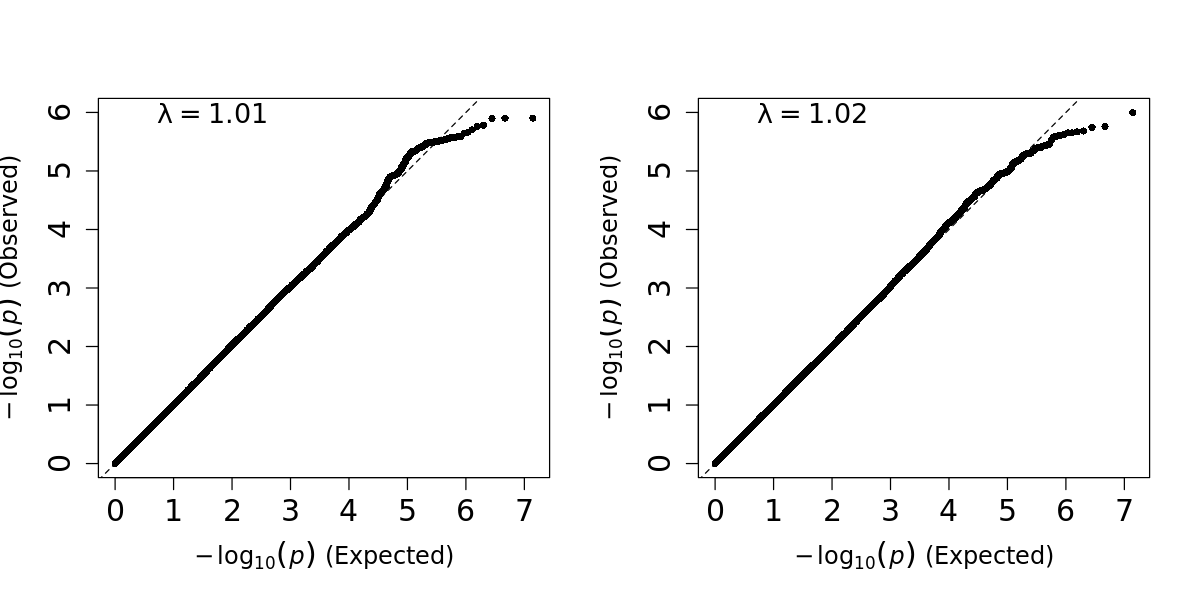

In [12]:
par(mfrow=c(1, 2))
make_qq(sex_res, "P_Value_Interaction")
make_qq(sex_res, "P_Value_Joint")

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



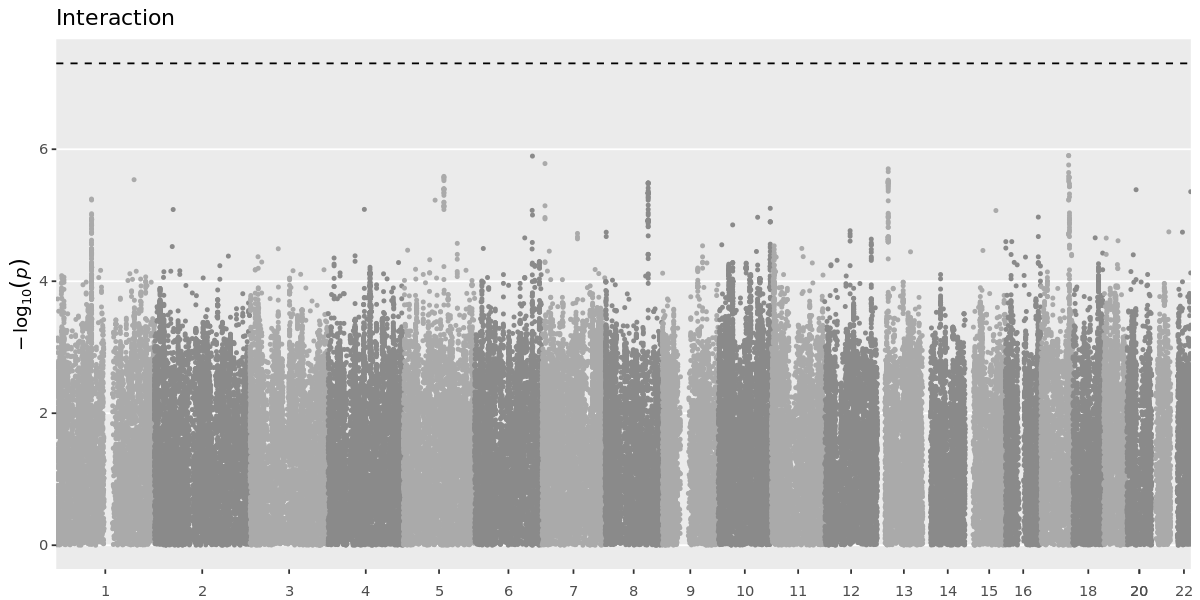

`summarise()` ungrouping output (override with `.groups` argument)



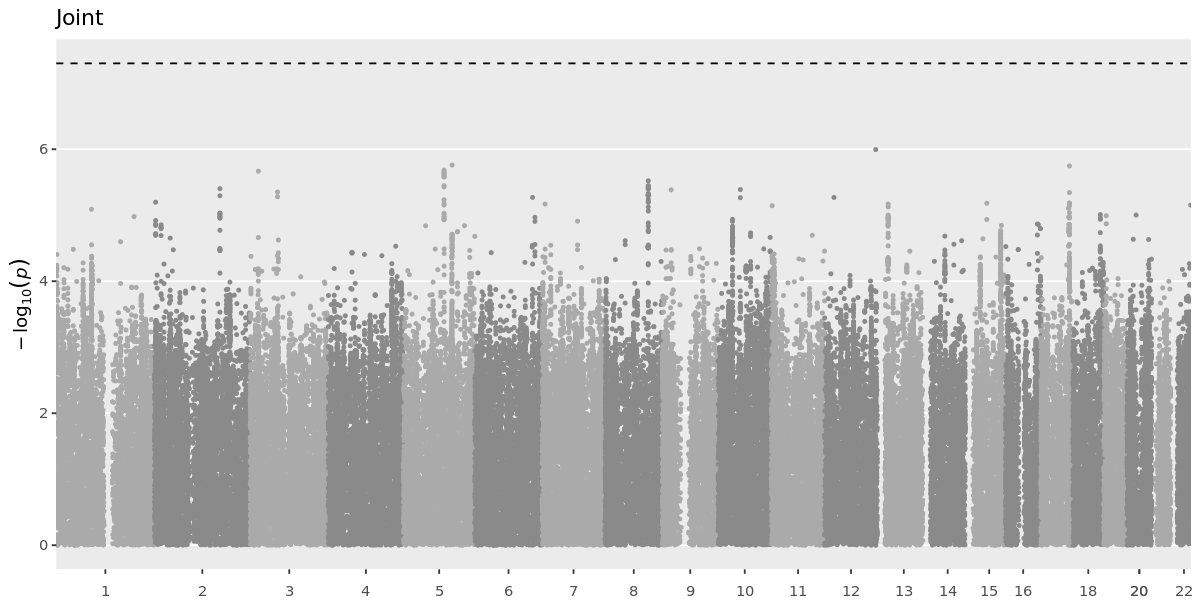

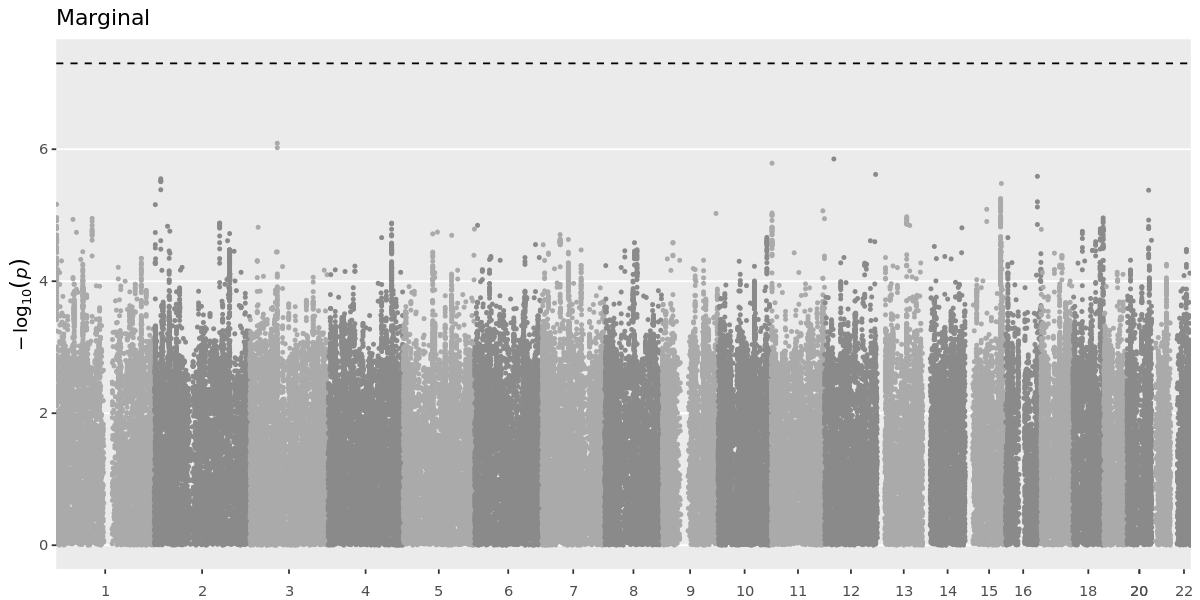

In [13]:
make_manhattan(sex_res, "P_Value_Interaction", main="Interaction")
make_manhattan(sex_res, "P_Value_Joint", main="Joint")
make_manhattan(sex_res, "P_Value_Marginal", main="Marginal")

### Cardiometaboic trait interactions

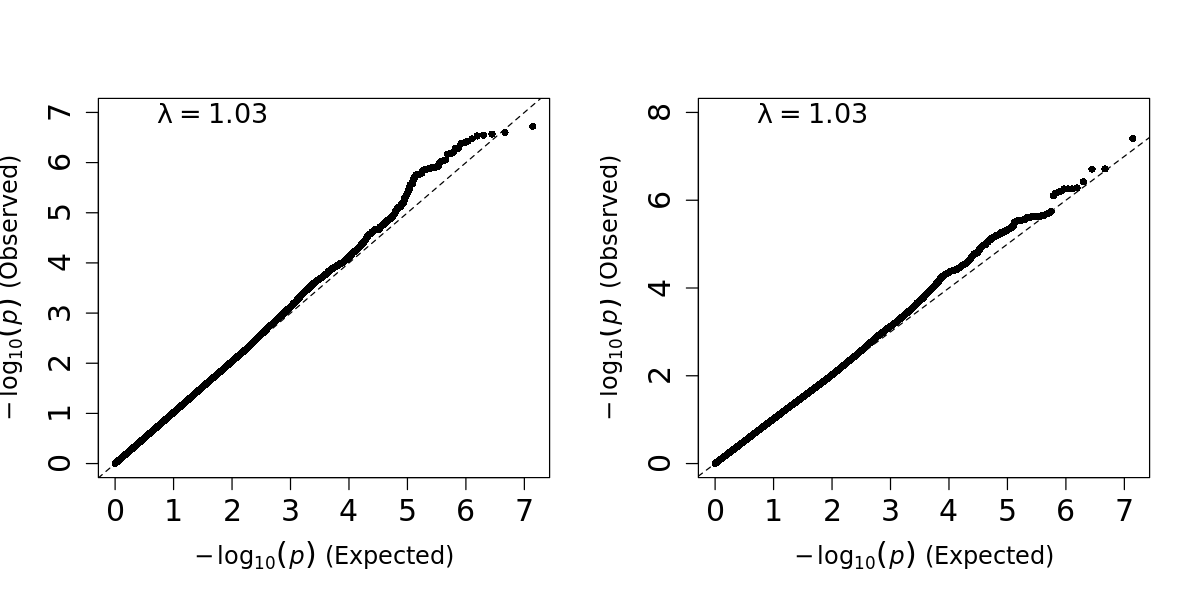

In [19]:
par(mfrow=c(1, 2))
make_qq(CM_res, "P_Value_Interaction")
make_qq(CM_res, "P_Value_Joint")

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



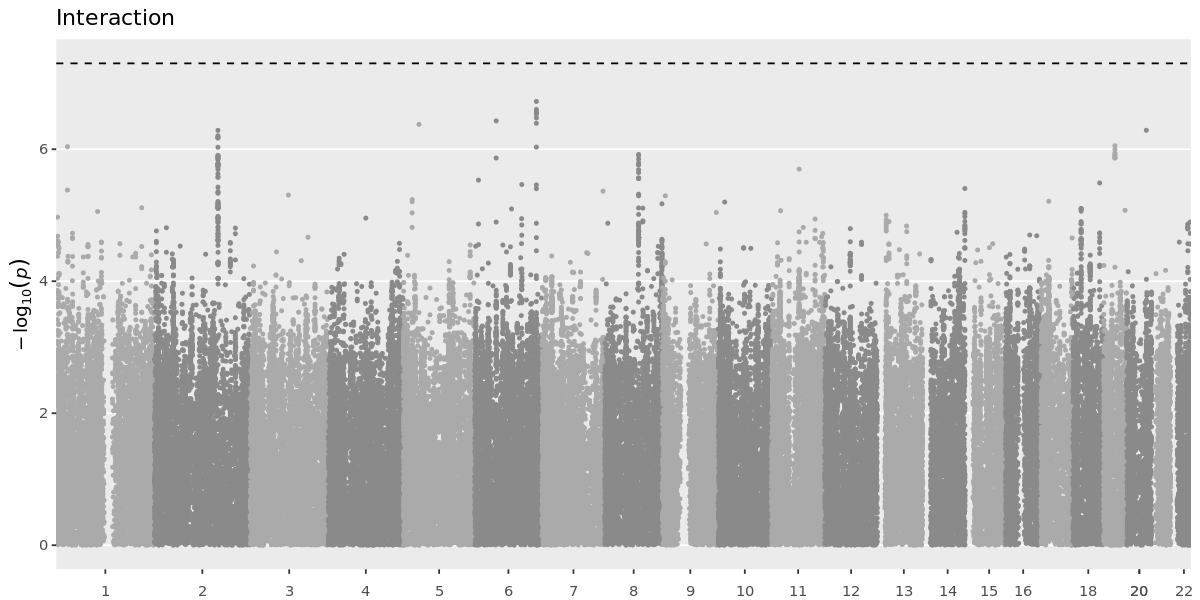

`summarise()` ungrouping output (override with `.groups` argument)



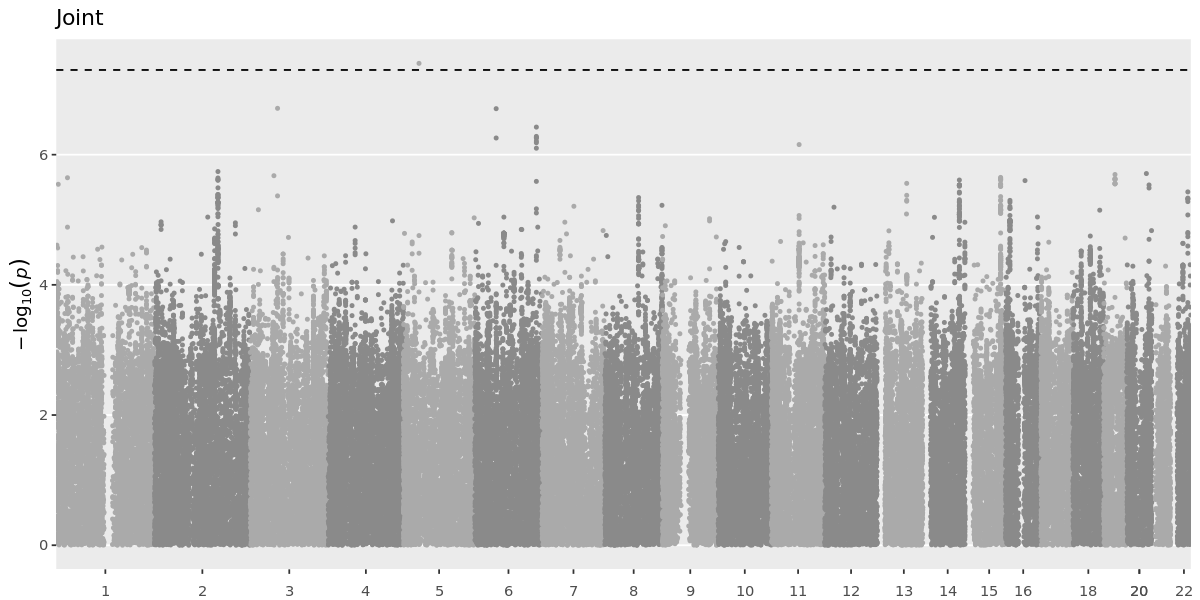

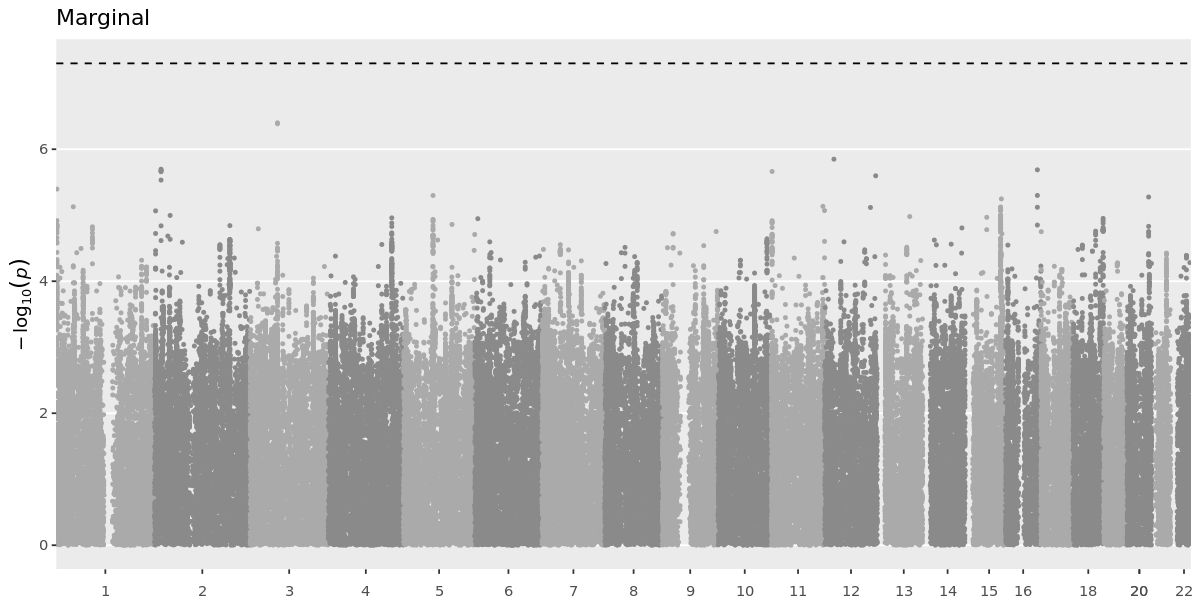

In [20]:
make_manhattan(CM_res, "P_Value_Interaction", main="Interaction")
make_manhattan(CM_res, "P_Value_Joint", main="Joint")
make_manhattan(CM_res, "P_Value_Marginal", main="Marginal")

### Social determinants of health interactions

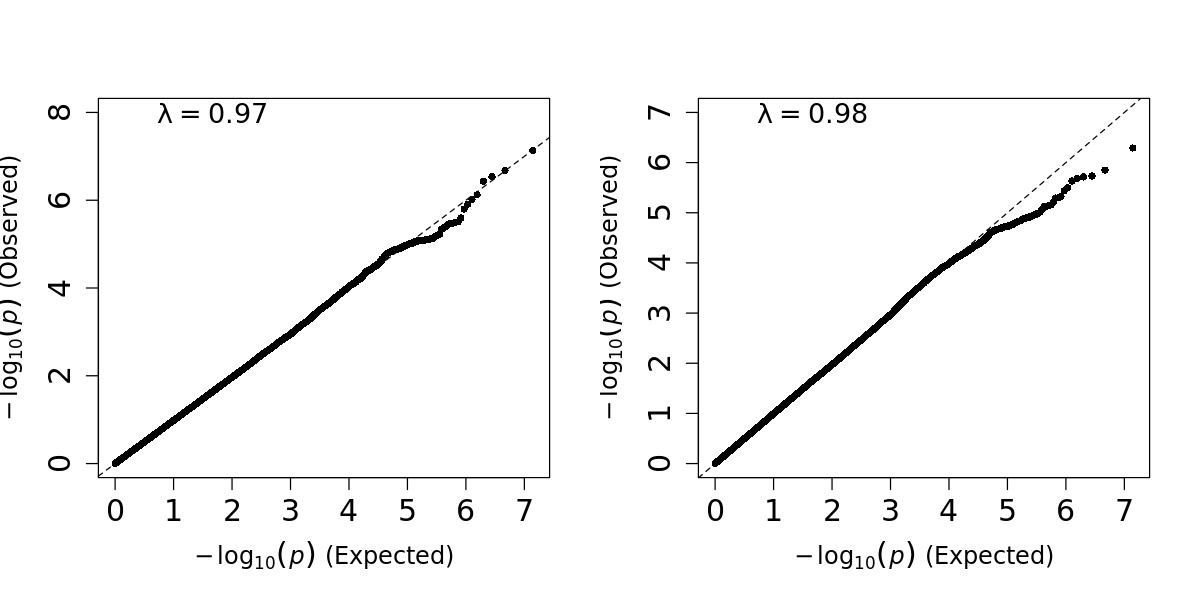

In [21]:
par(mfrow=c(1, 2))
make_qq(sdh_res, "P_Value_Interaction")
make_qq(sdh_res, "P_Value_Joint")

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



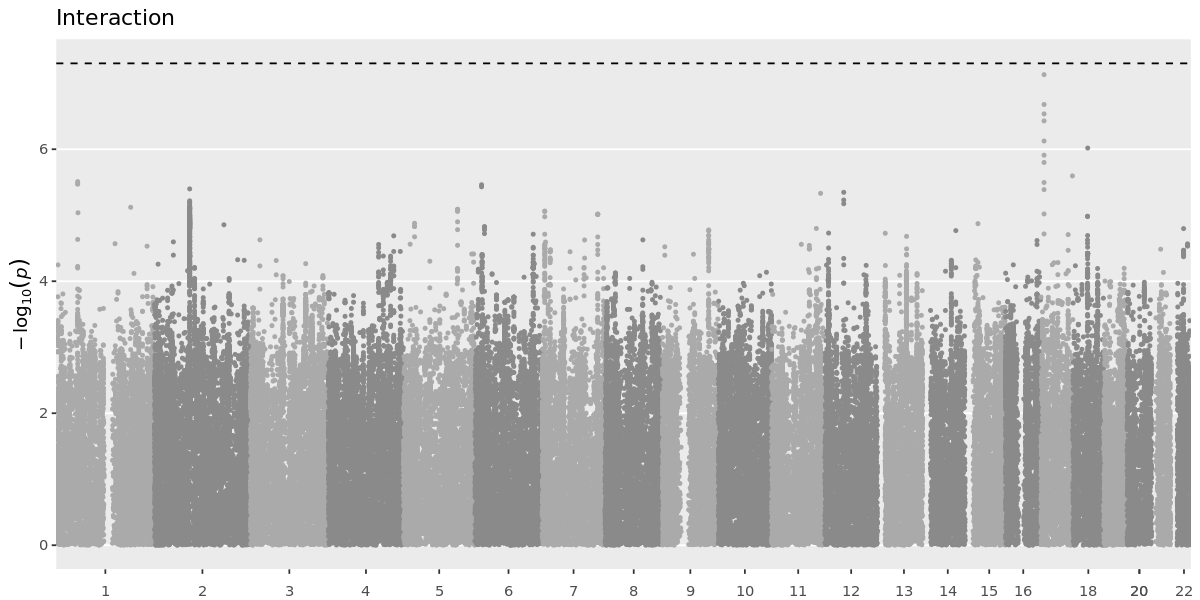

`summarise()` ungrouping output (override with `.groups` argument)



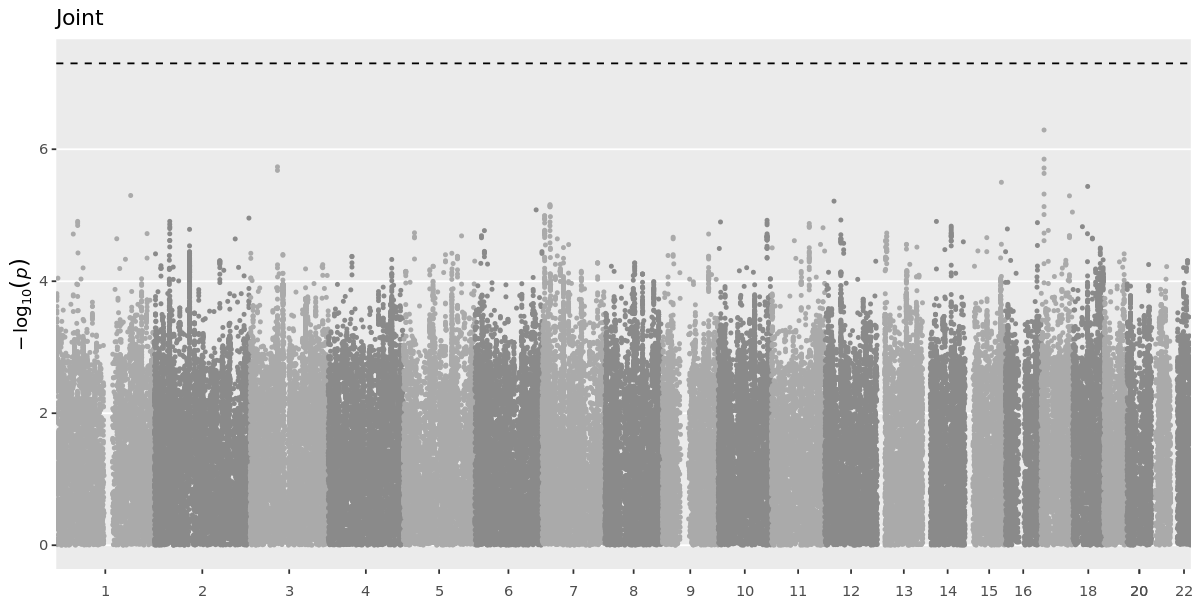

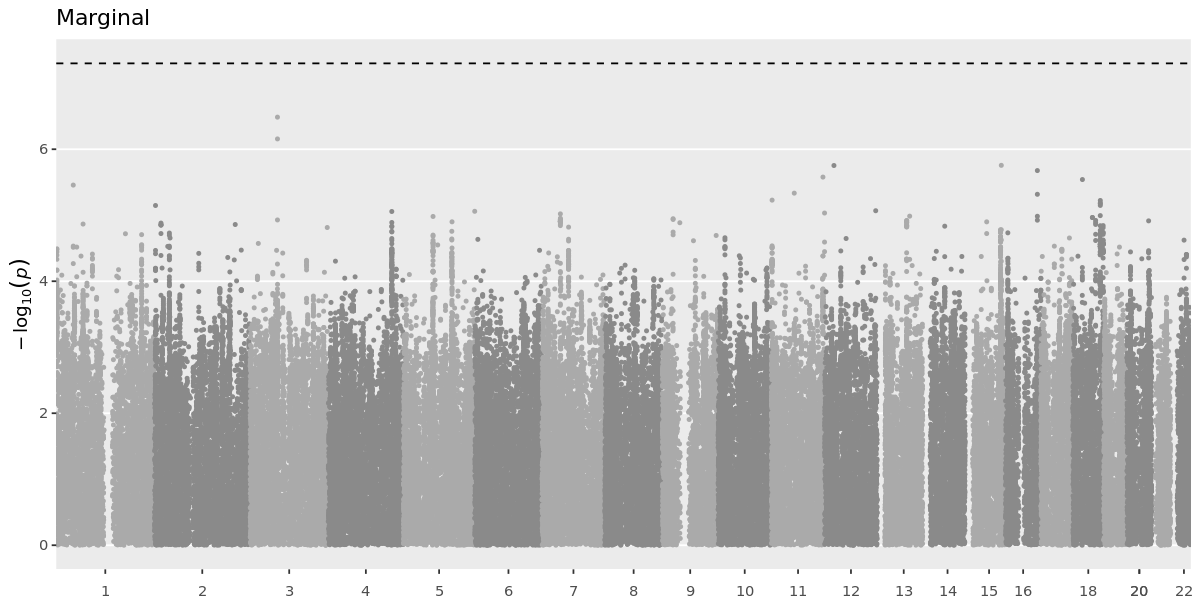

In [22]:
make_manhattan(sdh_res, "P_Value_Interaction", main="Interaction")
make_manhattan(sdh_res, "P_Value_Joint", main="Joint")
make_manhattan(sdh_res, "P_Value_Marginal", main="Marginal")

## Pruning

In [14]:
prune_chromosome <- function(chr_df, pval_col, locus_width) {
  # Prune variants given a chromosome-specific summary statistic data frame
  df <- arrange(chr_df, !!sym(pval_col))  # Sort by ascending p-value
  pruned_df <- tibble()
  while(nrow(df) > 0) {
    pruned_df <- bind_rows(pruned_df, df[1, ])  # Add lowest p-value to pruned dataset
    df <- filter(df, (POS < df$POS[1] - locus_width / 2) |  # Remove rest of variants in that distance-based locus
                   (POS > df$POS[1] + locus_width / 2))
  }
  pruned_df
}

prune_suggestive_variants <- function(ss_df, pval_col, sugg_thresh=1e-6, locus_width=500000) {
  # Prune variants across all chromosomes using a simple distance-based approach
  ss_df %>%
    filter(!!sym(pval_col) < sugg_thresh) %>%
    nest(data=-CHR) %>%
    mutate(pruned_ss=map(data, prune_chromosome, pval_col, locus_width)) %>%
    unnest(pruned_ss) %>%
    select(-data) %>%
    dplyr::rename(index_var=RSID)
}

# sex_res_int_pruned <- prune_suggestive_variants(sex_res, "P_Value_Interaction")
sex_res_int_pruned <- tibble()
sex_res_joint_pruned <- prune_suggestive_variants(sex_res, "P_Value_Joint")
joint_CM_res_int_pruned <- prune_suggestive_variants(joint_CM_res, "P_Value_Interaction")
joint_CM_res_joint_pruned <- prune_suggestive_variants(joint_CM_res, "P_Value_Joint")

### Export potential hits for retrieval of genotypes and downstream testing

In [15]:
# sex_int_sugg_rsids <- sex_res_int_pruned$index_var
sex_joint_sugg_rsids <- sex_res_joint_pruned$index_var
joint_CM_int_sugg_rsids <- joint_CM_res_int_pruned$index_var
joint_CM_joint_sugg_rsids <- joint_CM_res_joint_pruned$index_var

all_sugg_rsids <- unique(c(sex_joint_sugg_rsids, joint_CM_int_sugg_rsids, joint_CM_joint_sugg_rsids))
write(all_sugg_rsids, "all_sugg_rsids.txt")
system(paste0("gsutil cp all_sugg_rsids.txt ", ws_bucket))

In [16]:
length(all_sugg_rsids)

[1] 295

In [17]:
head(sex_res_joint_pruned)

CHR,SNPID,index_var,POS,Non_Effect_Allele,Effect_Allele,N_Samples,AF,Beta_Marginal,Var_Beta_Marginal,Beta_Interaction_1,Var_Beta_Interaction_1_1,P_Value_Marginal,P_Value_Interaction,P_Value_Joint
<int>,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1:91733994_T_A,rs12727804,91733994,T,A,378054,0.0585600,-0.502478,0.00757353,0.1002280,0.0299959,7.74653e-09,5.62786e-01,2.86991e-08
1,1:215152131_A_G,rs17544265,215152131,A,G,378054,0.0836123,-0.226063,0.00741552,0.6729960,0.0274746,8.66045e-03,4.90312e-05,4.02151e-08
1,1:196599502_AC_A,1:196599502_AC_A,196599502,AC,A,378054,0.0534819,-0.417422,0.00925102,-0.4205130,0.0407669,1.42540e-05,3.72791e-02,3.49393e-07
1,1:29634625_A_G,rs12743391,29634625,A,G,378054,0.1205490,-0.298063,0.00545359,-0.4267550,0.0236478,5.43349e-05,5.51799e-03,5.03956e-07
1,1:3432993_G_A,rs11587498,3432993,G,A,378054,0.1200040,-0.216376,0.00586121,0.5504090,0.0222695,4.70911e-03,2.25725e-04,5.87036e-07
2,2:34017430_C_T,rs12465135,34017430,C,T,378054,0.0801986,-0.477402,0.00771740,0.0324733,0.0313369,5.49938e-08,8.54451e-01,3.63419e-07


In [18]:
ws_bucket

[1] "gs://fc-secure-c6a040fa-b0ae-4612-8055-51776fde40dc"

In [19]:
sex_res_joint_pruned %>% write_csv("sex_res_joint_pruned.csv")
system("gsutil cp sex_res_joint_pruned.csv gs://fc-secure-c6a040fa-b0ae-4612-8055-51776fde40dc/")

## QC/sensitivity analysis for robustness

Concern is that the combination of case-control imbalance + low MAF is causing spurious hits for some of these variants.

### Read in subset of interesting SNPs (dosages)

In [20]:
phenos <- fread("covid_interaction_phenotypes_EUR.csv", data.table=F, stringsAsFactors=F) %>%
  mutate(id = as.character(id))

In [21]:
suggestive_bgen <- "gs://fc-secure-c6a040fa-b0ae-4612-8055-51776fde40dc/8959703f-a934-4cdc-8313-d56e9cd0fd9f/subset_genotypes/1db65a35-8f25-465b-898e-bd23686f40ea/call-concatenate/concat.bgen"
system(paste0("gsutil cp ", suggestive_bgen, " suggestive.bgen"))
suggestive_sample <- "gs://fc-secure-c6a040fa-b0ae-4612-8055-51776fde40dc/ukb27892_imp_chrAUT_v3_s487395.sample"
system(paste0("gsutil cp ", suggestive_sample, " suggestive.sample"))

In [22]:
if (!require(bgenR)) devtools::install_github("https://github.com/duytpm16/bgenR")

bgenInfo <- open_bgen("suggestive.bgen")
snp_df <- tibble(id = bgenInfo$SampleID)
print(bgenInfo$M)
for (i in 1:bgenInfo$M) {
    next_snp <- query_bgen()
    snp_df[[next_snp$RSID]] <- next_snp$Dosages
}
close_bgen()

followup_df <- inner_join(phenos, snp_df, by="id")

Loading required package: bgenR



[1] 333
End of BGEN file has been reached. Please close the file with close_bgen().


[1] "BGEN file closed successfully."

In [23]:
names(followup_df)

[1] "id"                                      
  [2] "ancestry"                                
  [3] "PC1"                                     
  [4] "PC2"                                     
  [5] "PC3"                                     
  [6] "PC4"                                     
  [7] "PC5"                                     
  [8] "PC6"                                     
  [9] "PC7"                                     
 [10] "PC8"                                     
 [11] "PC9"                                     
 [12] "PC10"                                    
 [13] "array"                                   
 [14] "sexMale"                                 
 [15] "age"                                     
 [16] "bmi"                                     
 [17] "t2d"                                     
 [18] "mdi"                                     
 [19] "case_b2"                                 
 [20] "case_b2_ds"                              
 [21] "rs11587498"                              
 [22] "rs12749381"                              
 [23] "rs10917279"                              
 [24] "rs150259986"                             
 [25] "rs199964615"                             
 [26] "rs12743391"                              
 [27] "rs143548691"                             
 [28] "rs56189421"                              
 [29] "rs546326368"                             
 [30] "rs58673429"                              
 [31] "rs766045013"                             
 [32] "1:64844999_GT_G"                         
 [33] "rs74611182"                              
 [34] "rs34631015"                              
 [35] "rs12727804"                              
 [36] "rs34258459"                              
 [37] "rs1563744"                               
 [38] "rs61784535"                              
 [39] "rs80155672"                              
 [40] "rs28730711"                              
 [41] "rs17186323"                              
 [42] "rs77795342"                              
 [43] "rs1321233"                               
 [44] "rs60532362"                              
 [45] "1:158768115_CTTAG_C"                     
 [46] "rs139511444"                             
 [47] "rs114812663"                             
 [48] "rs17350502"                              
 [49] "rs4652653"                               
 [50] "rs12035009"                              
 [51] "1:186741685_CT_C"                        
 [52] "rs540661143"                             
 [53] "1:196599502_AC_A"                        
 [54] "rs17544265"                              
 [55] "rs35728271"                              
 [56] "rs11579322"                              
 [57] "rs10427264"                              
 [58] "rs12465135"                              
 [59] "rs185072513"                             
 [60] "rs116402615"                             
 [61] "rs141405091"                             
 [62] "rs921072"                                
 [63] "rs7560093"                               
 [64] "rs62132706"                              
 [65] "rs79956769"                              
 [66] "rs67457437"                              
 [67] "rs10170054"                              
 [68] "rs79685083"                              
 [69] "rs148895400"                             
 [70] "rs113459905"                             
 [71] "rs1145069"                               
 [72] "rs72911730"                              
 [73] "2:213118879_TA_T"                        
 [74] "rs62182258"                              
 [75] "rs72963417"                              
 [76] "rs115443069"                             
 [77] "rs16829377"                              
 [78] "rs2675309"                               
 [79] "3:5690426_TTTG_T"                        
 [80] "rs73020965"                              
 [81] "rs73043633"                              
 [82] "rs150111100"              

### Calculation of minor alle counts across case and exposure strata

In [24]:
minMAC_df <- followup_df %>%
  select(sexMale, case_b2, any_of(sex_joint_sugg_rsids)) %>%
  group_by(sexMale, case_b2) %>%
  summarise_all(~sum(pmin(., 2 - .))) %>%  # Sum of dosages or 2 - dosages if major allele is counted
  pivot_longer(names_to="RSID", values_to="MAC", !c("sexMale", "case_b2")) %>%
  group_by(RSID) %>%
  summarise(minMAC = min(MAC))

`summarise()` ungrouping output (override with `.groups` argument)



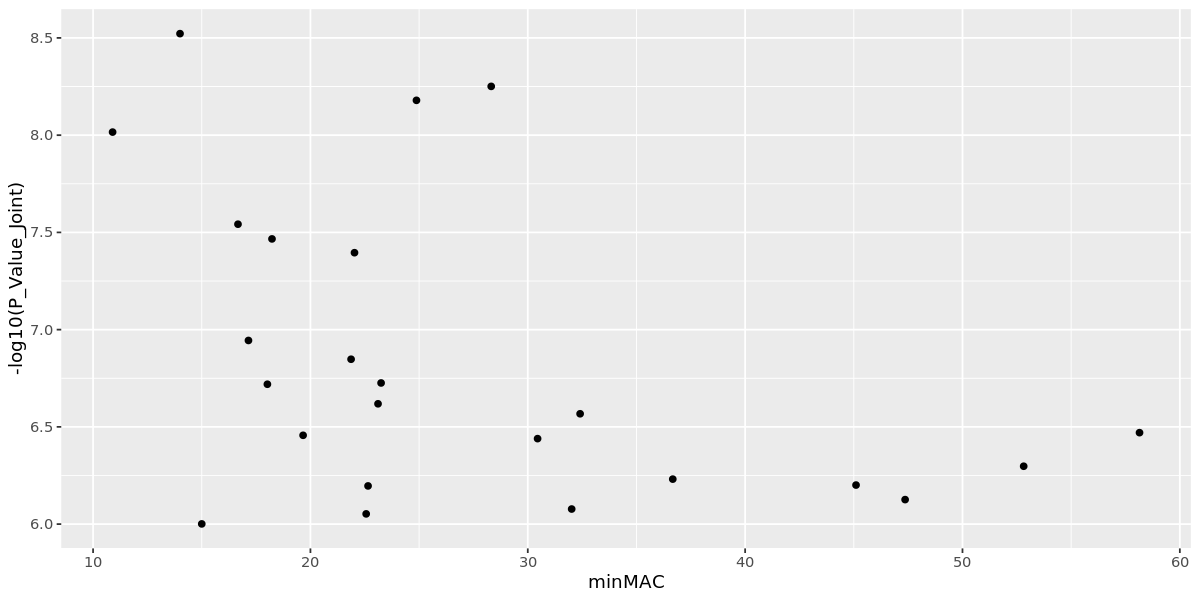

In [25]:
sex_res_joint_pruned %>%
  rename(RSID=index_var) %>%
  inner_join(minMAC_df, by="RSID") %>%
  ggplot(aes(x=minMAC, y=-log10(P_Value_Joint))) +
  geom_point()

"minMAC" here is the minimum minor allele count across all combinations of sex (exposure) and case status (outcome). We see here that there is some inverse correlation between minMAC and joint p-value, as would be expected since we are not using a SPA approximation. However, these MACs are still above thresholds that have been used before for interaction analysis (ex. minimum minMAC of 10 was used in Sung et al. 2016, *Genet. Epidemiol.*). A couple of variants in particular look promising, with minMAC > 20 and joint p-value < 1e-8.

### SPAGE

In [26]:
if (!require(SPAGE)) devtools::install_github('WenjianBi/SPAGE', dep=F)

Loading required package: SPAGE



In [27]:
nullmod <- SPAGE_Null_Model(case_b2 ~ sexMale + age + PC1 + PC2 + PC3, 
                 subjectID = followup_df$id, 
                 data = followup_df, 
                 out_type="D")
env_mat <- matrix(followup_df$sex, dimnames=list(followup_df$id, "sex"))
geno_mat <- as.matrix(followup_df[, sex_joint_sugg_rsids])
rownames(geno_mat) <- followup_df$id

spage_res <- SPAGE(obj.null=nullmod, 
      Envn.mtx=env_mat, 
      Geno.mtx=geno_mat,
      Cutoff=0,
      BetaG.SPA=TRUE) %>%
  as.data.frame() %>%
  rownames_to_column(var="RSID")

spage_res_noSPA <- SPAGE(obj.null=nullmod, 
      Envn.mtx=env_mat, 
      Geno.mtx=geno_mat,
      Cutoff=0,
      BetaG.SPA=FALSE) %>%
  as.data.frame() %>%
  rownames_to_column(var="RSID")

[1] "Warnings: please make sure subjects in Covariates, Genotype and Environmental factor dataset are of the same order."
[1] "Sample size is 378054."
[1] "Number of variants is 24."
[1] "Start Analyzing..."


Warning message in if (is.na(mu)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(mu)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(mu)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(mu)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(mu)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(mu)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(mu)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(mu)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(mu)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na

[1] "Warnings: please make sure subjects in Covariates, Genotype and Environmental factor dataset are of the same order."
[1] "Sample size is 378054."
[1] "Number of variants is 24."
[1] "Start Analyzing..."


Warning message in if (is.na(mu)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(mu)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(mu)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(mu)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(mu)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(mu)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(mu)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(mu)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(mu)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na

Joining, by = "RSID"



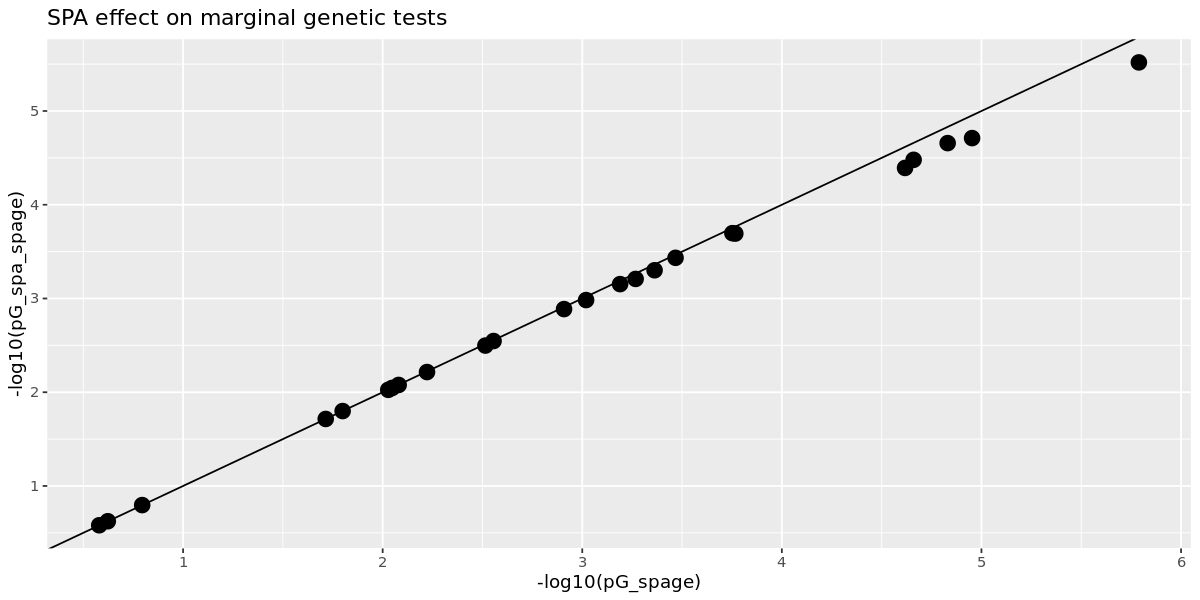

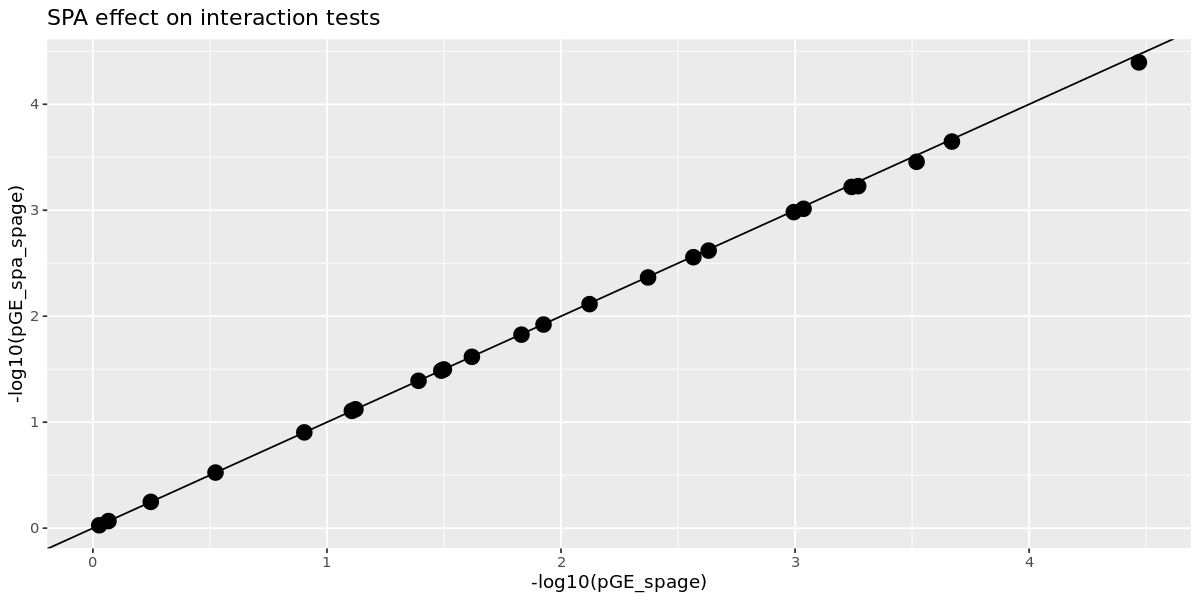

In [28]:
spa_compare <- inner_join(
  select(spage_res, RSID, pG_spa_spage=p.value.BetaG, pGE_spage=`p.value.norm-sex`, pGE_spa_spage=`p.value.spa-sex`),
  select(spage_res_noSPA, RSID, pG_spage=p.value.BetaG)
)

spa_compare %>%
  ggplot(aes(x=-log10(pG_spage), y=-log10(pG_spa_spage))) + 
  geom_point(size=4) +
  geom_abline(slope=1, intercept=0) +
  scale_color_continuous(type="viridis") + 
  labs(title="SPA effect on marginal genetic tests")

spa_compare %>%
  ggplot(aes(x=-log10(pGE_spage), y=-log10(pGE_spa_spage))) +
  geom_point(size=4) +
  geom_abline(slope=1, intercept=0) +
  scale_color_continuous(type="viridis") + 
  labs(title="SPA effect on interaction tests")

# a <- inner_join(
#   select(sex_res_joint_pruned, RSID=index_var, CHR, POS, AF, pG_gem=P_Value_Marginal, pGE_gem=P_Value_Interaction, pJ_gem=P_Value_Joint),
#   select(spage_res_df, RSID, pG_spage=p.value.BetaG, pGE_spage=`p.value.norm-sex`, pGE_spa_spage=`p.value.spa-sex`),
#   by="RSID"
# ) %>%
#   inner_join(mac_df, by="RSID") %>%
#   mutate(minMAC = pmin(minMAC, 50))

Before comparing to GEM results, we can check whether the saddlepoint approximation (SPA) is having a substantial impact on p-values. The results above show that there is minimal impact of the SPA on either marginal or interaction p-values. The SPA raises p-values just slightly for the more-significant marginal test variants.

In [29]:
spage_compare <- spa_compare %>%
  inner_join(select(sex_res_joint_pruned, RSID=index_var, 
                    pG_gem=P_Value_Marginal, pGE_gem=P_Value_Interaction, pJ_gem=P_Value_Joint),
             by="RSID") %>%
  inner_join(minMAC_df, by="RSID")

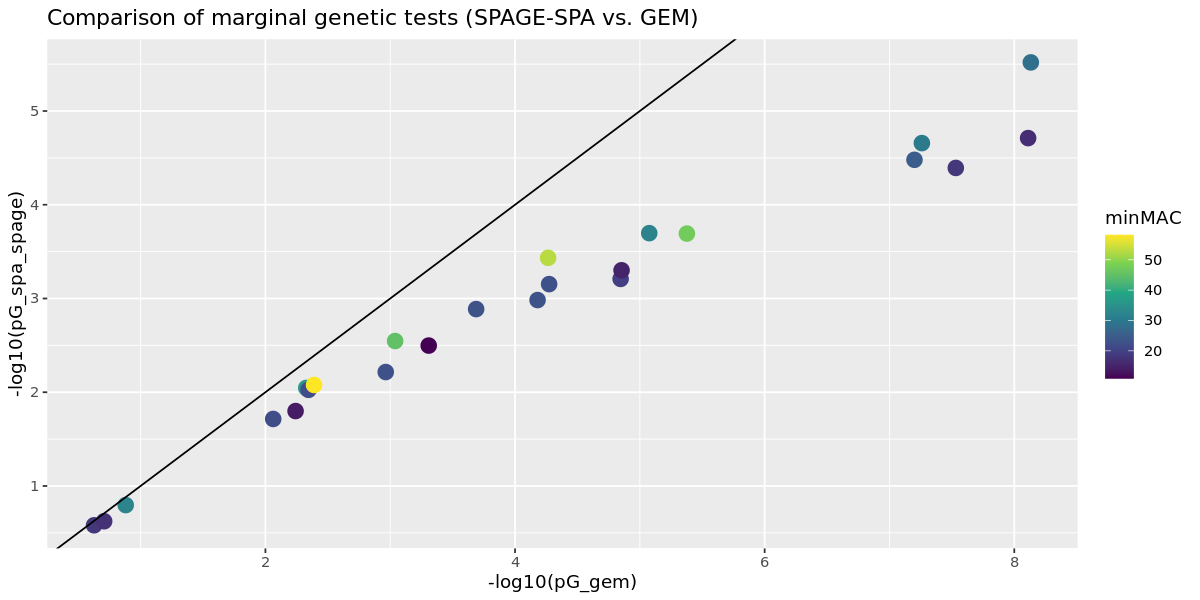

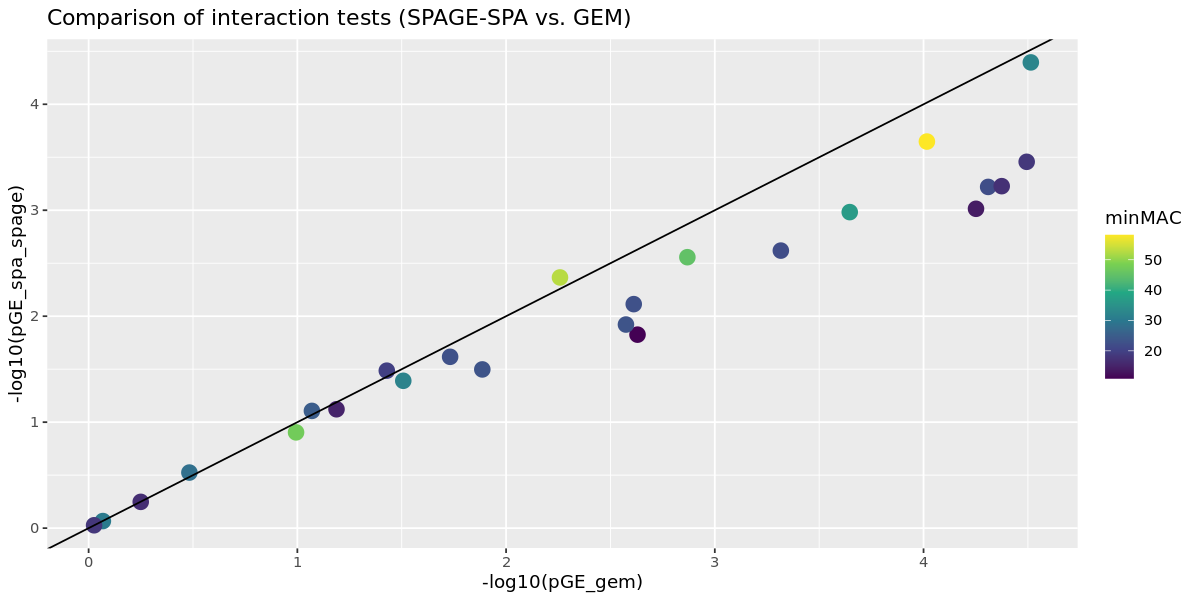

In [30]:
spage_compare %>%
ggplot(aes(x=-log10(pG_gem), y=-log10(pG_spa_spage), color=minMAC)) +
geom_point(size=4) +
geom_abline(slope=1, intercept=0) +
scale_color_continuous(type="viridis") + 
labs(title="Comparison of marginal genetic tests (SPAGE-SPA vs. GEM)")

spage_compare %>%
ggplot(aes(x=-log10(pGE_gem), y=-log10(pGE_spa_spage), color=minMAC)) +
geom_point(size=4) +
geom_abline(slope=1, intercept=0) +
scale_color_continuous(type="viridis") + 
labs(title="Comparison of interaction tests (SPAGE-SPA vs. GEM)")

# a %>%
# ggplot(aes(x=-log10(pGE_gem), y=-log10(pGE_spa_spage), color=minMAC)) +
# geom_point(size=4) +
# geom_abline(slope=1, intercept=0) +
# scale_color_continuous(type="viridis") + 
# labs(title="Comparison of interaction tests (using SPAGE SPA)")

P-values for the marginal test are very different between SPAGE (with or without SPA) and GEM. Interaction p-values are somewhat smaller for some variants, but substantially less so than for the marginal test. So, it doesn't seem that the potentially-spurious p-values are explained away by case-control imbalance and the SPA, but it is unclear what accounts for the discrepancy between SPAGE and GEM. Robust standard errors could be responsible for the difference (used in GEM but not in SPAGE).

In [31]:
head(spage_compare)

,RSID,pG_spa_spage,pGE_spage,pGE_spa_spage,pG_spage,pG_gem,pGE_gem,pJ_gem,minMAC
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,rs12727804,1.945610e-05,0.5659638745,0.565220317,1.113966e-05,7.74653e-09,5.62786e-01,2.86991e-08,16.66667
2,rs17544265,1.929201e-02,0.0005731808,0.000602438,1.928887e-02,8.66045e-03,4.90312e-05,4.02151e-08,22.02745
3,1:196599502_AC_A,6.187180e-04,0.0324729801,0.032667265,5.402390e-04,1.42540e-05,3.72791e-02,3.49393e-07,19.66275
4,rs12743391,3.682742e-04,0.0042465364,0.004307749,3.408175e-04,5.43349e-05,5.51799e-03,5.03956e-07,52.81569
5,rs11587498,9.004598e-03,0.0010123916,0.001041681,8.959812e-03,4.70911e-03,2.25725e-04,5.87036e-07,36.67059
6,rs12465135,2.200752e-05,0.8582942101,0.857786282,1.476675e-05,5.49938e-08,8.54451e-01,3.63419e-07,30.45098


In [34]:
if (!require(sandwich)) install.packages("sandwich")
library(lmtest)

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




In [38]:
sandwich(a)
sqrt(sandwich(a)[3,3])

,(Intercept),scale(sexMale),rs12727804,age,PC1,PC2,PC3,scale(sexMale):rs12727804
(Intercept),0.105684076,-1.494971e-03,-3.313259e-03,-1.781786e-03,-0.0085891906,2.669290e-02,0.0469728860,2.131127e-03
scale(sexMale),-0.001494971,1.528489e-03,2.871990e-04,1.964469e-05,-0.0096223844,-5.745916e-03,0.0127862883,-1.499237e-03
rs12727804,-0.003313259,2.871990e-04,2.620696e-02,2.981463e-05,-0.0132453650,-9.496307e-03,0.0173406431,-7.034828e-03
age,-0.001781786,1.964469e-05,2.981463e-05,3.052186e-05,0.0006627061,-9.188499e-06,-0.0007829412,-3.062539e-05
PC1,-0.008589191,-9.622384e-03,-1.324536e-02,6.627061e-04,13.2309615416,7.827448e+00,-0.2849649328,3.156213e-02
PC2,0.026692898,-5.745916e-03,-9.496307e-03,-9.188499e-06,7.8274484520,1.426504e+01,0.3405579155,1.723139e-02
PC3,0.046972886,1.278629e-02,1.734064e-02,-7.829412e-04,-0.2849649328,3.405579e-01,13.2071990365,-1.260735e-02
scale(sexMale):rs12727804,0.002131127,-1.499237e-03,-7.034828e-03,-3.062539e-05,0.0315621291,1.723139e-02,-0.0126073487,2.508173e-02


[1] 0.1618856

In [35]:
a <- glm(case_b2 ~ scale(sexMale) * rs12727804 + age + PC1 + PC2 + PC3,
            data=followup_df, family="binomial")
coeftest(a, vcov = vcovHC(a, type="HC1"))


z test of coefficients:

                            Estimate Std. Error  z value  Pr(>|z|)    
(Intercept)               -7.5719166  0.3250943 -23.2914 < 2.2e-16 ***
scale(sexMale)             0.2162513  0.0390963   5.5312 3.180e-08 ***
rs12727804                -0.6936888  0.1618874  -4.2850 1.827e-05 ***
age                        0.0227445  0.0055247   4.1169 3.841e-05 ***
PC1                       -8.4585532  3.6374774  -2.3254   0.02005 *  
PC2                       -6.2020535  3.7769491  -1.6421   0.10057    
PC3                       -4.1260882  3.6342095  -1.1353   0.25623    
scale(sexMale):rs12727804  0.0937204  0.1583738   0.5918   0.55401    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


We can also test this using a basic general linear model with an interaction term. Picking the top joint test variant (rs12727804) to start, we see the following:
* GEM marginal: p ~ 8e-9
* SPAGE marginal: p ~ 1e-5
* Raw GLM: p ~ 1e-5 (agreeing with SPAGE)
* Raw GLM w/ robust SEs: p ~ 1.8e-5

## TODO
* GEM model using R code w/ robust and non-robust
* Why doesn't SPA change marginal p-values for SPAGE? (try w/ SPAtest, no interaction)
* GEM w/ non-robust

In [49]:
reg_GE <- function(y, X, G, E, IC, robust=FALSE, family = "gaussian") {
  S <- X[, c(E, IC)] * G
  q <- length(E)
  mod <- glm(y ~ G + S + X, family = family)
  covmod <- if(robust) sandwich(mod)[2:(2+q), 2:(2+q)] else vcov(mod)[2:(2+q), 2:(2+q)]
  beta <- summary(mod)$coef[2:(2+q), 1]
  pval_int <- pchisq(c(t(beta[2:(1+q)]) %*% solve(covmod[2:(1+q), 2:(1+q)], beta[(2:(1+q))])), q, lower = F)
  pval_joint <- pchisq(crossprod(beta[1:(1+q)], solve(covmod[1:(1+q), 1:(1+q)], beta[1:(1+q)])), 1+q, lower = F)
  mod <- glm(y ~ G + X, family = family)
  varmod <- if(robust) sandwich(mod)[2, 2] else vcov(mod)[2, 2]
  betaG <- summary(mod)$coef[2, 1]
  pval_main <- pchisq(betaG^2/varmod, 1, lower = F)
  #return(c(pval_main, pval_int, pval_joint, betaG, beta[-1], varmod, c(covmod[-1, -1])))
  return(c(pval_main, pval_int, pval_joint, betaG, beta[-1], varmod, c(covmod[-1, -1]), beta[1], c(covmod[1,])))
}
proj_GE_log_prepare <- function(y, X) {
  nullmod <- glm(y ~ X, family = "binomial")
  mu <- nullmod$fitted.values
  res <- y - mu
  w <- mu * (1-mu)
  X <- cbind(1, X)
  return(list(res=res, w=w, XW=X*w, XWX_i=solve(crossprod(X*w, X)), X=X))
}
proj_GE_log <- function(nullmod, G, E, robust=TRUE) {
  GS <- nullmod$X[, 1+c(0, E)] * G
  q <- length(E)
  GS <- GS - nullmod$X %*% crossprod(nullmod$XWX_i, crossprod(nullmod$XW, GS))
  varmod0 <- 1/sum(nullmod$w*GS[,1]^2)
  varmod <- if(robust) varmod0^2*sum(nullmod$res^2*GS[,1]^2) else varmod0
  betaG <- varmod0*crossprod(GS[,1], nullmod$res)
  #GS <- GS[,-1] - varmod0 * GS[,1] %*% crossprod(GS[,1]*nullmod$w, GS[,-1])
  covmod0 <- solve(crossprod(GS*nullmod$w, GS))
  covmod <- if(robust) crossprod(covmod0, crossprod(crossprod(GS*nullmod$res^2, GS), covmod0)) else covmod0
  pval_main <- pchisq(betaG^2/varmod, 1, lower = F)
  beta_int <- as.numeric(crossprod(covmod0, crossprod(GS, nullmod$res)))
  stat_int <- crossprod(beta_int[-1], solve(covmod[-1,-1], beta_int[-1]))
  pval_int <- pchisq(stat_int, q, lower = F)
  pval_joint <- pchisq(crossprod(beta_int, solve(covmod, beta_int)), 1+q, lower = F)
  return(c(pval_main, pval_int, pval_joint, betaG, beta_int[-1], varmod, c(covmod[-1,-1]), beta_int[1], c(covmod[1,])))
}
proj_GE_lin_prepare <- function(y, X) {
  nullmod <- lm(y ~ X)
  res <- nullmod$residuals
  X <- cbind(1, X)
  return(list(res=res, sigma2=summary(nullmod)$sigma^2, XX_i=solve(crossprod(X)), X=X))
}
proj_GE_lin <- function(nullmod, G, E, robust=TRUE) {
  GS <- nullmod$X[, 1+c(0, E)] * G
  q <- length(E)
  GS <- GS - nullmod$X %*% crossprod(nullmod$XX_i, crossprod(nullmod$X, GS))
  varmod0 <- 1/sum(GS[,1]^2)
  varmod <- if(robust) varmod0^2*sum(nullmod$res^2*GS[,1]^2) else varmod0*nullmod$sigma2
  betaG <- varmod0*crossprod(GS[,1], nullmod$res)
  #GS <- GS[,-1] - varmod0 * GS[,1] %*% crossprod(GS[,1], GS[,-1])
  covmod0 <- solve(crossprod(GS))
  covmod <- if(robust) crossprod(covmod0, crossprod(crossprod(GS*nullmod$res^2, GS), covmod0)) else covmod0*nullmod$sigma2
  pval_main <- pchisq(betaG^2/varmod, 1, lower = F)
  beta_int <- as.numeric(crossprod(covmod0, crossprod(GS, nullmod$res)))
  stat_int <- crossprod(beta_int[-1], solve(covmod[-1,-1], beta_int[-1]))
  pval_int <- pchisq(stat_int, q, lower = F)
  pval_joint <- pchisq(crossprod(beta_int, solve(covmod, beta_int)), 1+q, lower = F)
  return(c(pval_main, pval_int, pval_joint, betaG, beta_int[-1], varmod, c(covmod[-1,-1]), beta_int[1], c(covmod[1,])))
}

In [51]:
y <- followup_df$case_b2
X <- as.matrix(select(followup_df, sexMale, age, PC1, PC2, PC3))
G <- followup_df$rs12727804
E <- "sexMale"
IC <- c()

# reg_GE(y, X, G, E, IC, robust=FALSE, family = "binomial")
# reg_GE(y, X, G, E, IC, robust=TRUE, family = "binomial")
proj_GE_lin(proj_GE_lin_prepare(y, X), G, 1, robust=FALSE)
proj_GE_lin(proj_GE_lin_prepare(y, X), G, 1, robust=TRUE)

1.127350e-05  5.662742e-01  5.513493e-05 -9.294872e-04 -2.435649e-04 
                                                              sexMale 
 4.480470e-08  1.803395e-07 -8.174003e-04  8.299657e-08 -8.299099e-08

7.478379e-09  4.618887e-01  2.791108e-08 -9.294872e-04 -2.435649e-04 
                                                              sexMale 
 2.586183e-08  1.095923e-07 -8.174003e-04  3.339071e-08 -3.339694e-08

In [47]:
filter(sex_res, RSID == "rs12727804")

SNPID,RSID,CHR,POS,Non_Effect_Allele,Effect_Allele,N_Samples,AF,Beta_Marginal,Var_Beta_Marginal,Beta_Interaction_1,Var_Beta_Interaction_1_1,P_Value_Marginal,P_Value_Interaction,P_Value_Joint
<chr>,<chr>,<int>,<int>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1:91733994_T_A,rs12727804,1,91733994,T,A,378054,0.05856,-0.502478,0.00757353,0.100228,0.0299959,7.74653e-09,0.562786,2.86991e-08
